In [142]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [238]:
data1 = np.random.normal(loc=3, scale=0.3, size=(3333, 1))
data2 = np.random.normal(loc=0, scale=0.3, size=(3333, 1))
data3 = np.random.normal(loc=-3, scale=0.3, size=(3333, 1))
# data2 = np.random.normal(loc=-3, scale=0.3, size=(10000, 1))
data = np.vstack([data1, data2, data3])

In [253]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim, output_dim, hidden_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def sample(self, batch_size):
        latent_vecs = torch.randn(batch_size, self.latent_dim)
        gens = self.layers(latent_vecs)
        return gens.view(batch_size, self.output_dim)

In [254]:
class Critic(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, gens):
        return self.layers(gens)

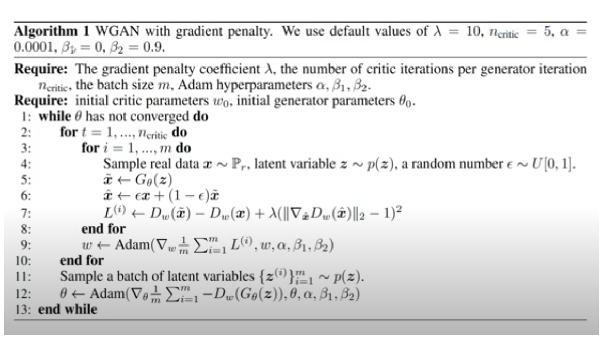

In [255]:
def gradient_penalty(critic, mixed):

    # Calculate critic scores
    mixed_scores = critic(mixed)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((nn.functional.relu(gradient_norm - 10)) ** 2)
    
    return gradient_penalty

  0%|          | 0/15000 [00:00<?, ?it/s]

0.035001590847969055


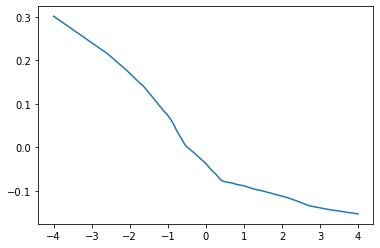

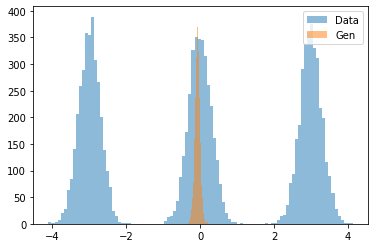

  7%|▋         | 993/15000 [00:12<02:39, 87.76it/s]

0.057723235338926315


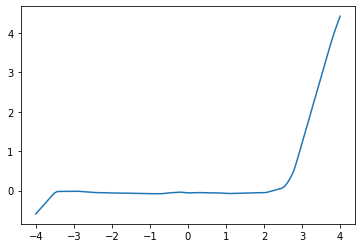

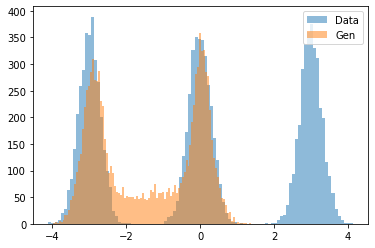

 13%|█▎        | 1995/15000 [00:25<02:30, 86.37it/s]

0.013592313975095749


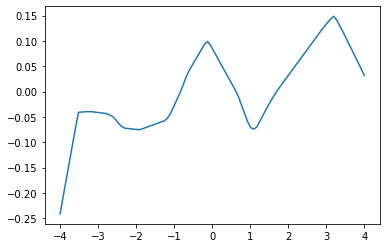

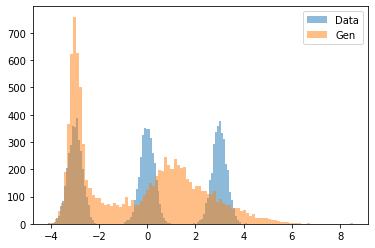

 20%|█▉        | 2992/15000 [00:38<02:35, 77.35it/s]

0.007532844319939613


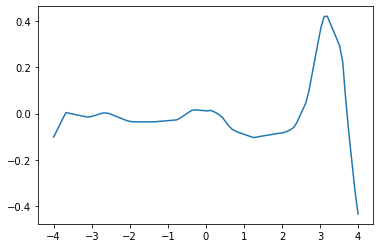

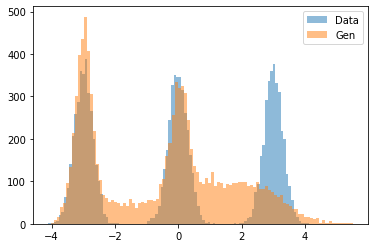

 27%|██▋       | 3999/15000 [00:51<02:24, 76.05it/s]

-0.004959346726536751


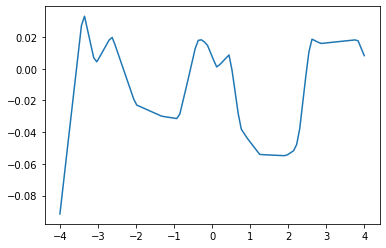

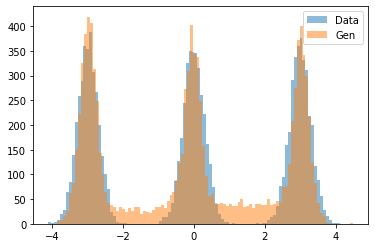

 33%|███▎      | 4999/15000 [01:04<01:56, 85.54it/s]

-0.015051573514938354


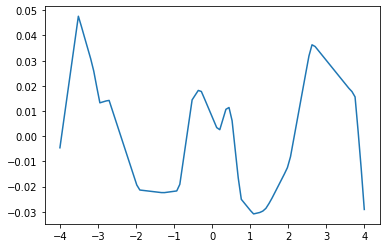

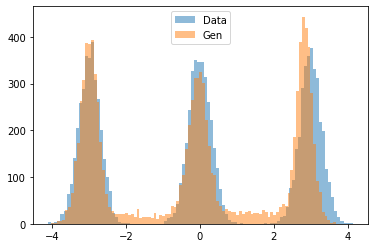

 40%|███▉      | 5993/15000 [01:18<01:45, 85.46it/s]

-0.005278041586279869


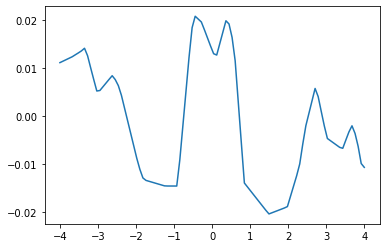

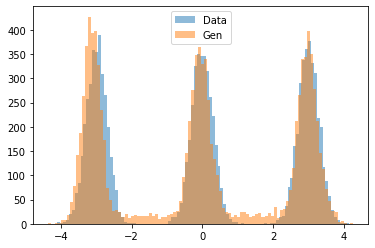

 47%|████▋     | 6996/15000 [01:31<01:44, 76.40it/s]

-0.004361268598586321


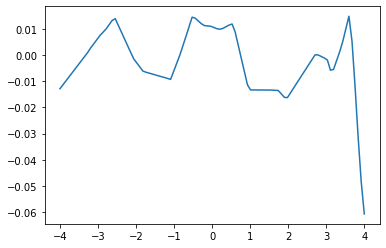

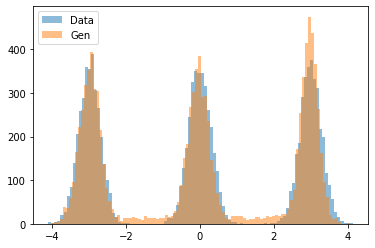

 53%|█████▎    | 7994/15000 [01:44<01:21, 85.58it/s]

-0.0033479887060821056


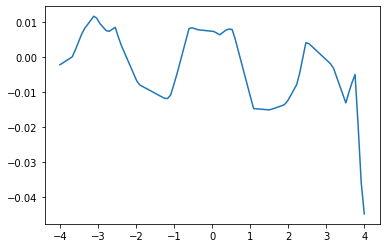

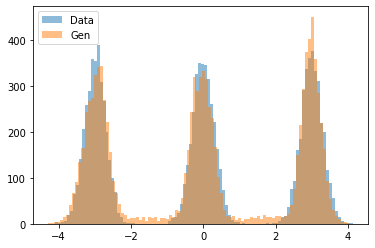

 60%|█████▉    | 8997/15000 [01:57<01:15, 79.81it/s]

-4.428683314472437e-05


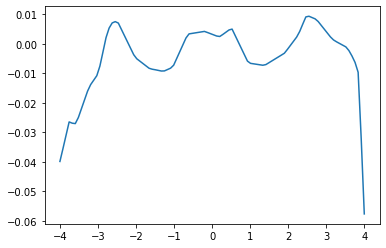

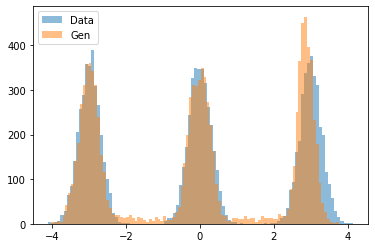

 67%|██████▋   | 9997/15000 [02:10<01:04, 78.04it/s]

-0.003636591602116823


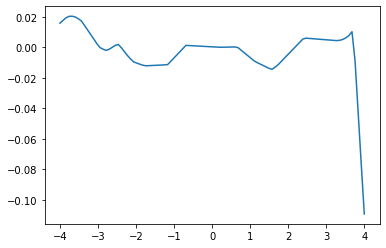

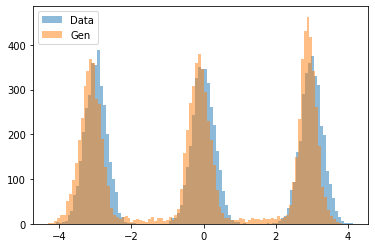

 73%|███████▎  | 10996/15000 [02:23<00:46, 85.29it/s]

-0.005515313241630793


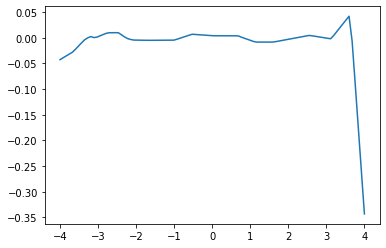

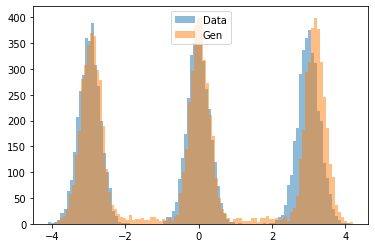

 80%|███████▉  | 11993/15000 [02:37<00:36, 83.36it/s]

-0.002870293101295829


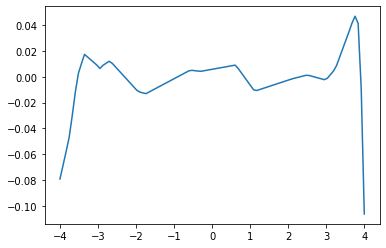

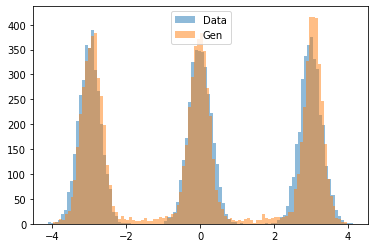

 87%|████████▋ | 12998/15000 [02:50<00:29, 67.60it/s]

2.875190693885088e-05


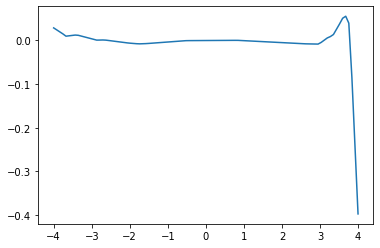

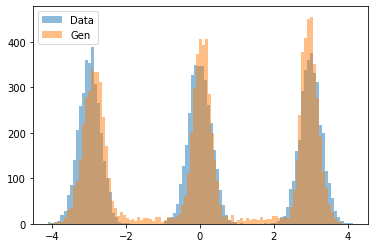

 93%|█████████▎| 13996/15000 [03:06<00:11, 85.18it/s]

-0.0026057877112179995


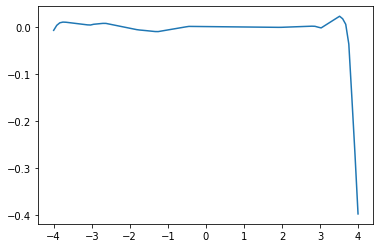

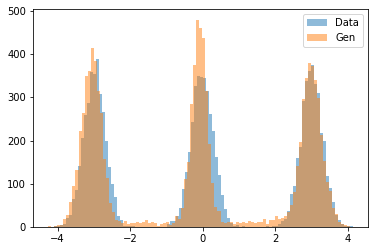

100%|██████████| 15000/15000 [03:19<00:00, 75.16it/s]


In [258]:
lr = 1e-3
betas = (0, 0.9)
batch_size = 64
λ = 1
λ2 = 5

G = Generator(latent_dim=32, output_dim=1).float()
D = Critic(input_dim=1).float()

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=betas)

for _ in tqdm(range(15000)):
        
    for i in range(5):
    
        true_data_batch = torch.from_numpy(data[np.random.randint(len(data), size=(batch_size, ))]).float()  # (batch_size, 1)
        fake_data_batch = G.sample(batch_size=batch_size)  # (batch_size, 1)
        
        random_nums_batch = torch.rand(batch_size, 1)
        
        mixed_batch = true_data_batch * random_nums_batch + fake_data_batch * (1 - random_nums_batch)
        
        loss = torch.mean(D(fake_data_batch) - D(true_data_batch)) + λ * gradient_penalty(D, mixed_batch) + λ2 * torch.mean(D(mixed_batch) ** 2)
        
        D_optimizer.zero_grad()
        loss.backward()
        D_optimizer.step()
        
    fake_data_batch = G.sample(batch_size=batch_size)  # (batch_size, 1)
    loss = torch.mean(-1 * D(G.sample(batch_size=batch_size)))
    
    G_optimizer.zero_grad()
    loss.backward()
    G_optimizer.step()
    
    if _ % 1000 == 0:
        
        print(loss.item())
        
        xs = np.linspace(-4, 4, 100)
        ys = D(torch.from_numpy(xs.reshape(-1, 1)).float()).detach().numpy().flatten()
        plt.plot(xs, ys)
        plt.show()
        
        plt.hist(data.flatten(), bins=100, alpha=0.5, label='Data')
        plt.hist(G.sample(batch_size=10000).detach().numpy().flatten(), bins=100, alpha=0.5, label='Gen')
        plt.legend()
        plt.show()

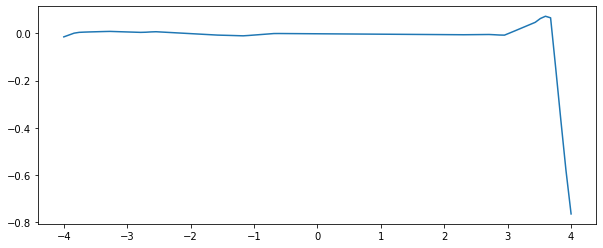

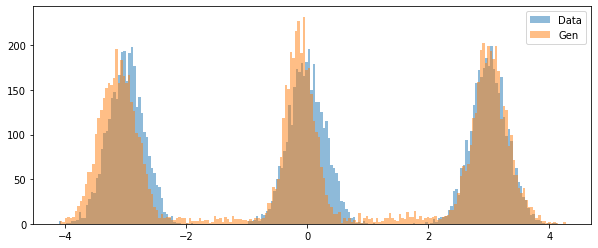

In [264]:
plt.figure(figsize=(10, 4))
xs = np.linspace(-4, 4, 100)
ys = D(torch.from_numpy(xs.reshape(-1, 1)).float()).detach().numpy().flatten()
plt.plot(xs, ys)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(data.flatten(), bins=200, alpha=0.5, label='Data')
plt.hist(G.sample(batch_size=10000).detach().numpy().flatten(), bins=200, alpha=0.5, label='Gen')
plt.legend()
plt.show()